In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
from torcheval.metrics import BinaryAUROC

from torch import Tensor
from jaxtyping import Float, Int

import plotly.express as px
import plotly.figure_factory as ff
import matplotlib.pyplot as plt
from scipy.stats import skew

import statsmodels.api as sm
import pandas as pd

from analysis import get_autoencoder_directions, plot_board, show_top_activating

from yeutong_utils import (
    pos_int2string,
    pos_string2int,
    gen_pattern_dict_from_pos,
    gen_pattern,
    plot_distribution_of_activations_legal,
    plot_distribution_of_activations_types,
    plot_distribution_of_activations_empty_legal,
    plot_distribution_of_activations_odd_even_empty_legal,
    plot_distribution_of_activations_previous_legal,
    plot_distribution_of_activations_pattern,
    plot_distribution_of_activations_patterns,
    plot_distribution_of_activations_pattern_legal,
)

device = "mps" if torch.backends.mps.is_available() else "cpu"

In [2]:
target_feature = 395
target_pos = 43

activations_location = "analysis_results/all_activations.pkl"
legal_moves_location = "analysis_results/all_legal_moves_me.pkl"
boards_location = "analysis_results/all_boards.pkl"

with open(activations_location, "rb") as f:
    all_activations = torch.load(f).detach()
with open(legal_moves_location, "rb") as f:
    all_legal_moves = torch.load(f).detach()
with open(boards_location, "rb") as f:
    all_boards = torch.load(f).detach()

In [3]:
pattern1 = gen_pattern() # Empty D6, Enemy: E6, Own: F6
pattern2 = gen_pattern(empty=["D6"], enemy=["D5"], own=["D4"])
pattern3 = gen_pattern(empty=["D6"], enemy=["D5", "D4"], own=["D3"])
pattern4 = gen_pattern(empty=["D6"], enemy=["E5"], own=["F4"])

patterns_dict = gen_pattern_dict_from_pos('D6')

print(len(patterns_dict))
print(patterns_dict.keys())


17
dict_keys(['right_1', 'right_2', 'right_3', 'left_1', 'left_2', 'up_1', 'up_2', 'up_3', 'up_4', 'down_1', 'up_right_1', 'up_right_2', 'up_right_3', 'up_left_1', 'up_left_2', 'down_right_1', 'down_left_1'])


104000
104000


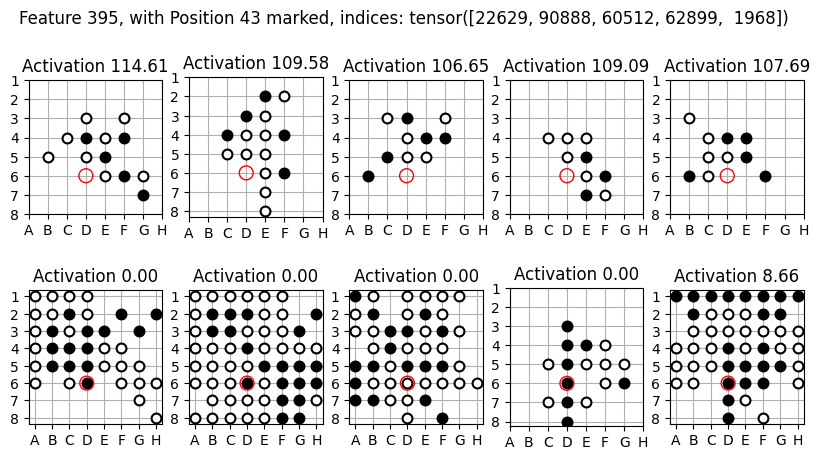

In [9]:
show_top_activating(target_feature, top_k=5, top_n=100, marked_position=target_pos)

In [5]:
# plot_distribution_of_activations_legal(target_feature, target_pos, ignore_zero=True)
# plot_distribution_of_activations_types(target_feature, target_pos, ignore_zero=True)
# plot_distribution_of_activations_empty_legal(target_feature, target_pos, ignore_zero=True)
# plot_distribution_of_activations_empty_legal(353, 18)
# plot_distribution_of_activations_empty_legal(727, 37)
# plot_distribution_of_activations_empty_legal(722, 26)
# plot_distribution_of_activations_odd_even_empty_legal(target_feature, target_pos)
# plot_distribution_of_activations_previous_legal(target_feature, target_pos)
# plot_distribution_of_activations_current_previous_legal(target_feature, target_pos)
# plot_distribution_of_activations_pattern(target_feature, target_pos)
plot_distribution_of_activations_pattern_legal(target_feature, target_pos, pattern=pattern1, pattern_name="Right_1")

# for pattern_name, pattern in patterns_dict.items():
#     plot_distribution_of_activations_pattern_legal(
#         target_feature, target_pos, pattern=pattern, pattern_name=pattern_name
#     )

# test different patterns
# plot_distribution_of_activations_pattern(target_feature, target_pos, pattern=pattern1)
# plot_distribution_of_activations_pattern(target_feature, target_pos, pattern=pattern2)
# plot_distribution_of_activations_pattern(target_feature, target_pos, pattern=pattern3)
# plot_distribution_of_activations_pattern(target_feature, target_pos, pattern=pattern4)

# plot_distribution_of_activations_patterns(target_feature, target_pos, patterns=[pattern1, pattern2, pattern3, pattern4])

### Regression
* predictor: patterns

In [5]:
# I want to run a regression model to predict the activation of a feature based on the pattern occurrence
# I will use the pattern as a feature, and the activation as the target

# first get boards and activations that D6 is empty
int_D6 = pos_string2int("D6")
boards_D6_empty = all_boards[all_boards[:, int_D6] == 0] # shape: (filtered_board 20420, 64)
these_activations = all_activations[:, target_feature]
activations_D6_empty = these_activations[all_boards[:, int_D6] == 0] # shape: (filtered_board 20420,)

# get the pattern occurrence for each board
# patterns come from patterns_dict
pattern_occurrence = torch.zeros((len(patterns_dict), boards_D6_empty.shape[0]), dtype=torch.int)
for pi, (pattern_name, pattern) in enumerate(patterns_dict.items()):
    relevant_positions = pattern != -1
    expanded_pattern = pattern[relevant_positions].unsqueeze(0)

    # Check for matches only at relevant positions
    matches = boards_D6_empty[:, relevant_positions] == expanded_pattern
    match_indices = matches.all(dim=1)
    pattern_occurrence[pi] = match_indices.int()

# now I have the pattern occurrence and activations, I can run a regression model
# I will use a simple linear regression model

X = pattern_occurrence.T.detach().numpy()
y = activations_D6_empty.detach().numpy()

X = pd.DataFrame(X, columns=patterns_dict.keys())
y = pd.Series(y, name="activation")

# add const
X = sm.add_constant(X)

# fit model
model = sm.OLS(y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             activation   R-squared:                       0.317
Model:                            OLS   Adj. R-squared:                  0.316
Method:                 Least Squares   F-statistic:                     556.7
Date:                Fri, 12 Apr 2024   Prob (F-statistic):               0.00
Time:                        18:05:36   Log-Likelihood:                -81935.
No. Observations:               20420   AIC:                         1.639e+05
Df Residuals:                   20402   BIC:                         1.640e+05
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           52.4113      0.132    396.084   

* predictor: important positions

In [29]:
positions = ['E6', 'F6', 'D5', 'D4', 'D3', 'E5', 'F4']
status = ['Enemy', 'Own'] # Empty as the base group
middle_four_pos = ['E5', 'E4', 'D5', 'D4']
pos_status_lst = [f'{pos}_{stat}' for pos in positions for stat in status if not (pos in middle_four_pos and stat == 'Own')]
print(pos_status_lst)

# first get boards and activations that D6 is empty
int_D6 = pos_string2int("D6")
boards_D6_empty = all_boards[all_boards[:, int_D6] == 0] # shape: (filtered_board 20420, 64)
these_activations = all_activations[:, target_feature]
activations_D6_empty = these_activations[all_boards[:, int_D6] == 0] # shape: (filtered_board 20420,)

# get status for each position
positions_status = torch.zeros((len(pos_status_lst), boards_D6_empty.shape[0]), dtype=torch.int)
for i, pos_stat in enumerate(pos_status_lst):
    pos, stat = pos_stat.split('_')
    int_pos = pos_string2int(pos)
    pos_status = boards_D6_empty[:, int_pos] == {"Enemy": 2, "Own": 1}[stat]

    positions_status[i] = pos_status

X = positions_status.T.detach().numpy()
y = activations_D6_empty.detach().numpy()

X = pd.DataFrame(X, columns=pos_status_lst)
y = pd.Series(y, name="activation")

# add const
X = sm.add_constant(X)

# fit model
model = sm.OLS(y, X).fit()

print(model.summary())

['E6_Enemy', 'E6_Own', 'F6_Enemy', 'F6_Own', 'D5_Enemy', 'D4_Enemy', 'D3_Enemy', 'D3_Own', 'E5_Enemy', 'F4_Enemy', 'F4_Own']
                            OLS Regression Results                            
Dep. Variable:             activation   R-squared:                       0.372
Model:                            OLS   Adj. R-squared:                  0.371
Method:                 Least Squares   F-statistic:                     1097.
Date:                Fri, 12 Apr 2024   Prob (F-statistic):               0.00
Time:                        20:54:01   Log-Likelihood:                -81084.
No. Observations:               20420   AIC:                         1.622e+05
Df Residuals:                   20408   BIC:                         1.623e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------

* predictor: important positions + patterns

In [41]:
positions = ['E6', 'F6', 'D5', 'D4', 'D3', 'E5', 'F4']
status = ['Enemy', 'Own'] # Empty as the base group
middle_four_pos = ['E5', 'E4', 'D5', 'D4']
pos_status_lst = [f'{pos}_{stat}' for pos in positions for stat in status if not (pos in middle_four_pos and stat == 'Own')]
print(pos_status_lst)

# first get boards and activations that D6 is empty
int_D6 = pos_string2int("D6")
boards_D6_empty = all_boards[all_boards[:, int_D6] == 0] # shape: (filtered_board 20420, 64)
these_activations = all_activations[:, target_feature]
activations_D6_empty = these_activations[all_boards[:, int_D6] == 0] # shape: (filtered_board 20420,)

# get status for each position
positions_status = torch.zeros((len(pos_status_lst) + 4, boards_D6_empty.shape[0]), dtype=torch.int)
for i, pos_stat in enumerate(pos_status_lst):
    pos, stat = pos_stat.split('_')
    int_pos = pos_string2int(pos)
    pos_status = boards_D6_empty[:, int_pos] == {"Enemy": 2, "Own": 1}[stat]

    positions_status[i] = pos_status

pattern_names = ['right_1', 'up_1', 'up_2', 'up_right_1']
for i, pattern_name in enumerate(pattern_names):
    pattern = patterns_dict[pattern_name]
    relevant_positions = pattern != -1
    expanded_pattern = pattern[relevant_positions].unsqueeze(0)

    # Check for matches only at relevant positions
    matches = boards_D6_empty[:, relevant_positions] == expanded_pattern
    match_indices = matches.all(dim=1)
    positions_status[len(pos_status_lst) + i] = match_indices.int()

X = positions_status.T.detach().numpy()
y = activations_D6_empty.detach().numpy()

X = pd.DataFrame(X, columns=pos_status_lst + pattern_names)
y = pd.Series(y, name="activation")

# add const
X = sm.add_constant(X)

# fit model
model = sm.OLS(y, X).fit()

print(model.summary())

['E6_Enemy', 'E6_Own', 'F6_Enemy', 'F6_Own', 'D5_Enemy', 'D4_Enemy', 'D3_Enemy', 'D3_Own', 'E5_Enemy', 'F4_Enemy', 'F4_Own']
                            OLS Regression Results                            
Dep. Variable:             activation   R-squared:                       0.395
Model:                            OLS   Adj. R-squared:                  0.395
Method:                 Least Squares   F-statistic:                     889.1
Date:                Sat, 13 Apr 2024   Prob (F-statistic):               0.00
Time:                        00:55:46   Log-Likelihood:                -80691.
No. Observations:               20420   AIC:                         1.614e+05
Df Residuals:                   20404   BIC:                         1.615e+05
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------

In [30]:
# simulation (start from a initial activation, then add the activation based status)

# first get the initial activation
df = X.copy()
df.drop(columns=["const"], inplace=True)

# gen label if any column is 1
legal_moves = all_legal_moves[:, int_D6]
df["label"] = legal_moves[all_boards[:, int_D6] == 0].detach().numpy()

df["initial_activation"] = np.random.normal(50, 8, X.shape[0])

# get the activation based on the pattern occurrence
pattern_coefficient = model.params[1:].to_dict()

# repalce 1 in df with the coefficient
for pattern_name, coefficient in pattern_coefficient.items():
    if pattern_name not in df.columns:
        continue
    df[pattern_name] = df[pattern_name] * coefficient

# sum the activation
df["activation"] = df.sum(axis=1)
df

# now I have the activation, I can plot the distribution group by label
fig = ff.create_distplot(
    hist_data=[df["activation"][df["label"] == 1], df["activation"][df["label"] == 0]],
    group_labels=["Empty + Legal", "Empty + Illegal"],
    bin_size=1,
)
fig.update_layout(
    title=f"Simulation of activation based on the regression estimation (position-wise)"
)
fig.show()

In [31]:
# deduct the estimated activation from the real activation
df = X.copy()
df.drop(columns=["const"], inplace=True)

# gen label if any column is 1
legal_moves = all_legal_moves[:, int_D6]

for pattern_name, coefficient in pattern_coefficient.items():
    if pattern_name not in df.columns:
        continue
    df[pattern_name] = df[pattern_name] * coefficient

# sum the activation
df["extra_activation"] = df.sum(axis=1)

df["label"] = legal_moves[all_boards[:, int_D6] == 0].detach().numpy()
df["real_activation"] = activations_D6_empty.detach().numpy()
df["estimated_activation"] = df["real_activation"] - df["extra_activation"]

# now I have the activation, I can plot the distribution group by label
fig = ff.create_distplot(
    hist_data=[df["estimated_activation"][df["label"] == 1], df["estimated_activation"][df["label"] == 0]],
    group_labels=["Empty + Legal", "Empty + Illegal"],
    bin_size=1,
)

fig.show()

In [32]:
# regression, position wise, include all positions

positions = [f'{l}{d}' for l in 'ABCDEFGH' for d in '12345678']
status = ['Enemy', 'Own'] # Empty as the base group
middle_four_pos = ['E5', 'E4', 'D5', 'D4']
pos_status_lst = [f'{pos}_{stat}' for pos in positions for stat in status if not ((pos in middle_four_pos and stat == 'Own') or (pos == 'D6'))]
print(pos_status_lst)

# first get boards and activations that D6 is empty
int_D6 = pos_string2int("D6")
boards_D6_empty = all_boards[all_boards[:, int_D6] == 0] # shape: (filtered_board 20420, 64)
these_activations = all_activations[:, target_feature]
activations_D6_empty = these_activations[all_boards[:, int_D6] == 0] # shape: (filtered_board 20420,)

# get status for each position
positions_status = torch.zeros((len(pos_status_lst), boards_D6_empty.shape[0]), dtype=torch.int)
for i, pos_stat in enumerate(pos_status_lst):
    pos, stat = pos_stat.split('_')
    int_pos = pos_string2int(pos)
    pos_status = boards_D6_empty[:, int_pos] == {"Enemy": 2, "Own": 1}[stat]

    positions_status[i] = pos_status

X = positions_status.T.detach().numpy()
y = activations_D6_empty.detach().numpy()

X = pd.DataFrame(X, columns=pos_status_lst)
y = pd.Series(y, name="activation")

# add const
X = sm.add_constant(X)

# fit model
model = sm.OLS(y, X).fit()

print(model.summary())

['A1_Enemy', 'A1_Own', 'A2_Enemy', 'A2_Own', 'A3_Enemy', 'A3_Own', 'A4_Enemy', 'A4_Own', 'A5_Enemy', 'A5_Own', 'A6_Enemy', 'A6_Own', 'A7_Enemy', 'A7_Own', 'A8_Enemy', 'A8_Own', 'B1_Enemy', 'B1_Own', 'B2_Enemy', 'B2_Own', 'B3_Enemy', 'B3_Own', 'B4_Enemy', 'B4_Own', 'B5_Enemy', 'B5_Own', 'B6_Enemy', 'B6_Own', 'B7_Enemy', 'B7_Own', 'B8_Enemy', 'B8_Own', 'C1_Enemy', 'C1_Own', 'C2_Enemy', 'C2_Own', 'C3_Enemy', 'C3_Own', 'C4_Enemy', 'C4_Own', 'C5_Enemy', 'C5_Own', 'C6_Enemy', 'C6_Own', 'C7_Enemy', 'C7_Own', 'C8_Enemy', 'C8_Own', 'D1_Enemy', 'D1_Own', 'D2_Enemy', 'D2_Own', 'D3_Enemy', 'D3_Own', 'D4_Enemy', 'D5_Enemy', 'D7_Enemy', 'D7_Own', 'D8_Enemy', 'D8_Own', 'E1_Enemy', 'E1_Own', 'E2_Enemy', 'E2_Own', 'E3_Enemy', 'E3_Own', 'E4_Enemy', 'E5_Enemy', 'E6_Enemy', 'E6_Own', 'E7_Enemy', 'E7_Own', 'E8_Enemy', 'E8_Own', 'F1_Enemy', 'F1_Own', 'F2_Enemy', 'F2_Own', 'F3_Enemy', 'F3_Own', 'F4_Enemy', 'F4_Own', 'F5_Enemy', 'F5_Own', 'F6_Enemy', 'F6_Own', 'F7_Enemy', 'F7_Own', 'F8_Enemy', 'F8_Own', 'G1_E

In [38]:
# deduct the estimated activation from the real activation
df = X.copy()
df.drop(columns=["const"], inplace=True)

# gen label if any column is 1
legal_moves = all_legal_moves[:, int_D6]

df["extra_activation"] = 0
pattern_coefficient_all = model.params[1:].to_dict()
for pattern_name, coefficient in pattern_coefficient_all.items():
    if pattern_name not in df.columns:
        continue
    if abs(model.tvalues[pattern_name]) < 5:
        continue
    df[pattern_name] = df[pattern_name] * coefficient
    df["extra_activation"] += df[pattern_name]
    # print(pattern_name, coefficient, model.tvalues[pattern_name])


df["label"] = legal_moves[all_boards[:, int_D6] == 0].detach().numpy()
df["real_activation"] = activations_D6_empty.detach().numpy()
df["estimated_activation"] = df["real_activation"] - df["extra_activation"]

# now I have the activation, I can plot the distribution group by label
fig = ff.create_distplot(
    hist_data=[df["estimated_activation"][df["label"] == 1], df["estimated_activation"][df["label"] == 0]],
    group_labels=["Empty + Legal", "Empty + Illegal"],
    bin_size=1,
)

fig.show()

In [40]:
df

A1_Enemy  A1_Own  A2_Enemy  A2_Own  A3_Enemy  A3_Own  A4_Enemy  A4_Own  \
0      0.000000       0         0       0         0       0         0       0   
1      0.000000       0         0       0         0       0         0       0   
2      0.000000       0         0       0         0       0         0       0   
3      0.000000       0         0       0         0       0         0       0   
4      0.000000       0         0       0         0       0         0       0   
...         ...     ...       ...     ...       ...     ...       ...     ...   
20415  0.000000       1         0       0         0       0         0       0   
20416  2.673936       0         0       0         0       0         0       0   
20417  0.000000       1         0       0         1       0         0       0   
20418  2.673936       0         0       0         0       1         0       0   
20419  0.000000       1         0       0         1       0         0       0   

       A5_Enemy  A5_Own  ...  H6_Enemy  H6_Own  H7_Enemy  H7_Own  H8_Enemy  \
0             0       0  ...         0       0  0.000000       0         0   
1             0       0  ...         0       0  0.000000       0         0   
2             0       0  ...         0       0  0.000000       0         0   
3             0       0  ...         0       0  0.000000       0         0   
4             0       0  ...         0       0  0.000000       0         0   
...         ...     ...  ...       ...     ...       ...     ...       ...   
20415         0       0  ...         0       0  2.393642       0         0   
20416         0       0  ...         0       0  0.000000       1         0   
20417         0       0  ...         0       0  2.393642       0         0   
20418         0       0  ...         0       0  0.000000       1         0   
20419         0       0  ...         0       0  2.393642       0         0   

       H8_Own  extra_activation  label  real_activation  estimated_activation  
0           0         14.731595      1        72.076920             57.345325  
1           0          8.439149      0        41.411800             32.972651  
2           0         24.829268      0        52.906387             28.077119  
3           0         27.917656      1        77.044090             49.126434  
4           0          6.812275      0        52.947739             46.135464  
...       ...               ...    ...              ...                   ...  
20415       0         16.671794      1        60.792381             44.120587  
20416       0         -3.965553      0        20.363605             24.329158  
20417       0         19.459467      1        66.990181             47.530714  
20418       0         -2.538165      1        40.358906             42.897070  
20419       0         23.303832      1        78.046501             54.742670  

[20420 rows x 126 columns]

In [5]:
# all_cells = [f"{chr(65 + i)}{j}" for i in range(8) for j in range(1, 9)]

# count = 0
# for cell in all_cells:
#     count += len(gen_pattern_dict_from_pos('D6'))

# print(count)

1088
